# EPIC: Elution Profile-based Inference of Protein Complex Membership

Welcome to the EPIC predictor Jupyter web service. Please use the Kitematic file organizes to upload the selected elution profiles. The following parameters need to be set in order to run EPIC.

In [23]:
import os
import warnings
import copy

warnings.filterwarnings('ignore')
root_dir = os.environ['HOME'] + os.sep + "work" + os.sep
os.chdir(root_dir + os.sep + "EPIC" + os.sep + "src" + os.sep)

import CalculateCoElutionScores as CS
import GoldStandard as GS
import utils as utils
from ipywidgets import widgets, interact, interactive
from IPython.display import HTML, display, Javascript
import json, sys, shutil, glob, fileupload

#Global paramters for input and output directory. These paramteres need to be changed if you want to run EPIC on local machine instead of Dockers
input_dir = root_dir + 'input' + os.sep 


projects =  []
for f in [f.split(os.sep)[-2] for f in glob.glob(input_dir+"*/")]:
    if not f.endswith("out"):
        projects.append(f)



def f(**kwargs):
    return None

directoryName_i = widgets.SelectMultiple(
    options=projects,
    value=[projects[0]],
    description='Input',
    disabled=False
)


features_i = interactive(f, MI=True, Bayes=True, Euclidean=True, WCC=False, Jaccard=True, PCCN=False, PCC=False, Apex=True)
num_cores_i = interactive(f, num_cores="1")
clf_i = widgets.RadioButtons(
    options=["Random forest", "SVM"],
    description='Classifier',
    disabled=False
)
target_species_i = interactive(f, target_species="taxid i.e. 6239 (Worm)")
mode_i = widgets.RadioButtons(
    options=['exp', 'comb'],
    description='Mode',
    disabled=False
)

fa_source_i = widgets.RadioButtons(
    options=['GM', 'STRING', 'FILE'],
    description='FA source',
    disabled=False
)

def _handle_upload(change):
    w = change['owner']
    with open("/tmp/" + w.filename, 'wb') as f:
        f.write(w.data)
    print('Uploaded to `{}` ({:.2f} kB)'.format(
        "/tmp/" + w.filename, len(w.data) / 2**10))
    
fa_dir = input_dir+os.sep+"fa_files"

fa_files = ["No File"]

if os.path.exists(fa_dir):
    for f in [f.split(os.sep)[-1] for f in glob.glob(fa_dir + os.sep + "*")]:
            fa_files.append(f)

print fa_files
            
fa_file = widgets.SelectMultiple(
    options=fa_files,
    value=[fa_files[0]],
    description='FA File select',
    disabled=False
)


    
ref_file = fileupload.FileUploadWidget()
ref_file.observe(_handle_upload, names='data')

# stdout for debug
# print input_dir
# print projects

['No File', 'WormNetV3_noZeros_no_physical_interactions.txt']


## Input directory
When starting the docker you linked one of your local folders with this docker image. This pipeline considers this folder as the input and output folder. In this folder EPIC expects a folder for each project, where each project fodler contains one elution profile file for each co-fractionation experiment. The elution profile file is a tab separated file where the first collumn contains a protein ID and each susequent collumn contains protein value for each fraction, and the file has one row for each protein. Additionally the file has an header line which contains the name of each feraction.

In [24]:
display(directoryName_i)

## Feature slection:
Please select which co-elution features should be used to generate the co-eluton network. We recommend using MI, Bayes, PCCN, and Apex.

In [25]:
display(features_i)

In [26]:
if sum([features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ])==0:
    print "Feature selection is empty! Please select at least one Feature"

## Num cores
Number of cores that can be used to calculate co-elution scores. Increasing this number reduces run time if the docher and the machine has multiple cores.

In [27]:
display(num_cores_i)

## Classifier:
Here you can select the classifier used to generate the co-elution profiles. EPIC supports both SVM and random forest. We recommend to use random forest.

In [28]:
display(clf_i)

## Reference data:
Here you can either supply an taxid for automatic generation of a reference, or upload a selected set of reference complexes. Please note automatic reference data gereneration is only supported by Uniprot IDs, and the format for the supplied reference complexes is one complex per line, in which the line contains all the cluster's member IDs separated by tabs.

In [29]:
display(target_species_i)
display(ref_file)

In [30]:
target_taxid = target_species_i.kwargs['target_species']
if target_taxid == "taxid i.e. 6239 (Worm)" and ref_file.filename=="":
    print "Please supply either target taxid or reference cluster file"
if target_taxid != "taxid i.e. 6239 (Worm)" and ref_file.filename!="":
    print "You gave both reference file and target taxid please choose only one"

#### Mode:
The mode which EPIC schould be run with. The supported modes are:  experiment only (exp), functional annotation only (fa), both (comb). We suggest to use experiment only when wanting to run EPIC without introducing functional annotation bias into the pipeline.

In [31]:
display(mode_i)

## Functional annotation data
Please select wich source for functional annotaiton to use. The user can eitehr autoamtically generate functional annotation from GeneMania (GM), or STRING. Alternativly, the user can suplly his own functional annotation data as falt file. In case the the mode is experimental only (exp, in mode selection), then this step can be skipped.

In [32]:
display(fa_source_i)
display(fa_file)

In [33]:
if fa_source_i.value != "FILE" and fa_file.value[0] != "No File":
    print "Selected %s as functional annotation, but still uploaded functional annotation file" % fa_source_i.value
if fa_source_i.value == "FILE" and fa_file.value[0]=="No File":
    print "Selected file for functional annotation data but no file has been uploaded, please ulpad functional annotation file"

In [34]:
featuer_selection = [features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ]
num_cores = int(num_cores_i.kwargs['num_cores'])
name = directoryName_i.value[0]
anno_source = fa_source_i.value
mode = mode_i.value

input_dir = root_dir + 'input' + os.sep  + name
output_dir = root_dir + 'input' + os.sep + name + "_out"

if os.path.exists(output_dir) == False: 
    os.mkdir(output_dir)
#else:
 #   print "Output dir already exists and removing content"
    #    shutil.rmtree(output_dir)
  #  os.mkdir(output_dir)
    
output_dir += os.sep + "Out"
target_taxid = target_species_i.kwargs['target_species']
use_rf = clf_i.value != 'SVM'
if use_rf:
    output_dir += ".rf"
else:
    output_dir += ".svm"
    
use_ref_file = False
ref_file_loc = "/tmp/" + ref_file.filename
if ref_file.filename !="": use_ref_file = True
     
use_fa_file = False
fa_file_loc = fa_dir + os.sep + fa_file.value[0]
if fa_file.value[0] !="No File": use_fa_file = True
    
#Create feature combination
all_scores = [CS.Pearson(), CS.Jaccard(), CS.Apex(), CS.MutualInformation(2), CS.Euclidiean(), CS.Wcc(), CS.Bayes(3), CS.Poisson(5)]
this_scores = []
for i, selection in enumerate(featuer_selection):
	if selection: this_scores.append(all_scores[i])

## Initializing the classifier

In [35]:
# Initialize CLF
clf = CS.CLF_Wrapper(num_cores, use_rf)

using Random forest


# Loading Elution profile data
EPIC loads in the elution data and removes proteins that are observed in exactly one fraction per experiment. Optimally the percentage of removed proteins should not exceed 50% 

In [36]:
# load elution data
print input_dir
foundprots, elution_datas = utils.load_data(input_dir, this_scores)

/home/jovyan/work/input/elution_profiles
finished processing /home/jovyan/work/input/elution_profiles/BeadsA_Contrast_1000_fraction_99.txtmodifed.txt
 removed 591 (0.32, total: 1839, after filtering: 1248) proteins found in less than 2 fraction
finished processing /home/jovyan/work/input/elution_profiles/BeadsALF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 563 (0.32, total: 1783, after filtering: 1220) proteins found in less than 2 fraction
finished processing /home/jovyan/work/input/elution_profiles/BeadsB_Contrast_1000_fraction_99.txtmodifed.txt
 removed 571 (0.28, total: 2027, after filtering: 1456) proteins found in less than 2 fraction
finished processing /home/jovyan/work/input/elution_profiles/BeadsBNF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 471 (0.28, total: 1696, after filtering: 1225) proteins found in less than 2 fraction


# Generating reference data
In this step EPIC automatically generate reference data taken from CORUM, Intact, and GO. We recommend the final number of complexes to be at least 100.

In [37]:
# Generate reference data set
import GoldStandard as GS
all_gs = ""
if use_ref_file:
    clusters = GS.Clusters(need_to_be_mapped=False)
    clusters.read_file(ref_file_loc)
    clusters.remove_proteins(foundprots)
    all_gs = GS.Goldstandard_from_Complexes("All")
    all_gs.complexes = clusters
    all_gs.make_pos_neg_ppis()
    print "Loaded %i complexes from file" % (len(all_gs.complexes.complexes))
else:
    all_gs = utils.create_goldstandard(target_taxid, foundprots)

Total number of complexes 3113 in Training
Number of complexes after ortholog mapping 2115 complexes in Training
After removing not indetified proteins 924 number of complexes in Training
After size filtering 157 number of complexes in Training
After mergning 119 number of complexes in Training


# Calculating co-elution scores
This is the most time intensive step of EPIC and on average take 20 min per co-elution score per experiment.

In [39]:
# Caculating scores
scoreCalc = CS.CalculateCoElutionScores(this_scores, elution_datas, output_dir + ".scores.txt", num_cores=num_cores)
scoreCalc.calculate_coelutionDatas(all_gs)
# For debug readin precalculated co-elution scores
#scoreCalc.readTable(output_dir + ".scores.txt", all_gs)

all_gs.positive = set(all_gs.positive & set(scoreCalc.ppiToIndex.keys()))
all_gs.negative = set(all_gs.negative & set(scoreCalc.ppiToIndex.keys()))
all_gs.rebalance()

In [40]:
functionalData = ""
if mode != "exp":
    functionalData = utils.get_FA_data(anno_source, fa_file_loc)
    print "Dimension of fun anno " + str(functionalData.scores.shape)
    tmp_sc = copy.deepcopy(scoreCalc)
    tmp_sc.add_fun_anno(functionalData)
    utils.cv_bench_clf(tmp_sc, clf, all_gs, output_dir, format="png")
else:
    utils.cv_bench_clf(scoreCalc, clf, all_gs, output_dir, format="png")

Dimension of fun anno (716809, 11)
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5


# Classifier evaluation

## Precision and recall values for various classifier confidence cutoffs

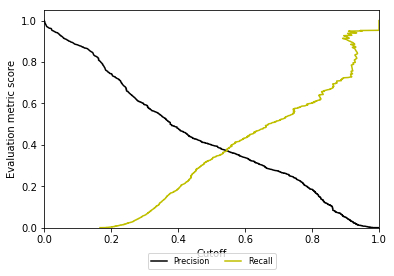

In [41]:
from IPython.display import Image
Image(filename=output_dir + ".cutoff.png")

## Precision-recall curve

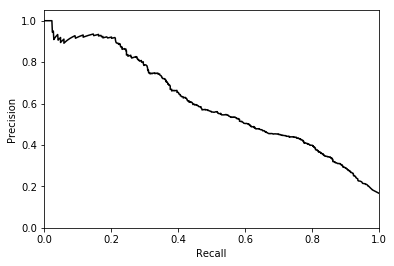

In [42]:
Image(filename=output_dir + ".pr.png")

## ROC curve

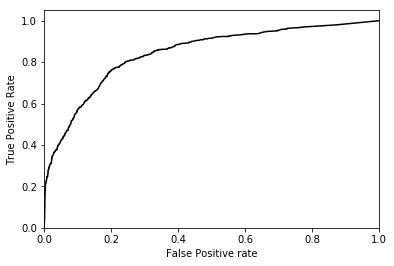

In [43]:
Image(filename=output_dir + ".roc.png")

## Prediction protein interaction network

In [44]:
# Predict protein interaction
network =  utils.make_predictions(scoreCalc, mode, clf, all_gs, functionalData)

outFH = open("%s.%s.pred.txt" % (output_dir, mode), "w")
print >> outFH, "\n".join(network)
outFH.close()

(4207, 4)
(4207, 15)
to predict: 102999
Completed chunk 1


## Prediction protein clusters

In [45]:
# Predicting clusters
utils.predict_clusters("%s.%s.pred.txt" % (output_dir, mode), "%s.%s.clust.txt" % (output_dir, mode))

# Clustering evaluation

In [46]:
import GoldStandard as GS
# Evaluating predicted clusters
pred_clusters = GS.Clusters(False)
pred_clusters.read_file("%s.%s.clust.txt" % (output_dir, mode))
s, h = utils.clustering_evaluation(all_gs.complexes, pred_clusters, "", True)

mmr	0.145402844263
overlapp	0.110553
simcoe	0.120603
mean_simcoe_overlap	0.120603
sensetivity	0.355463347165
ppv	0.502074688797
accuracy	0.42245609169
sep	0.206633647938


In [ ]:
# Uncomment these lines in order to update the Cytoscape.js extension
# ====================================================================
import notebook.nbextensions
notebook.nbextensions.install_nbextension('https://cdnjs.cloudflare.com/ajax/libs/cytoscape/2.7.14/cytoscape.js', user=True)
# ====================================================================

In [ ]:
%%javascript

// Use the Cytoscape.js extension and make cytoscape global
require(['nbextensions/cytoscape'], function (cytoscape) {
    window.cytoscape = cytoscape;
});

In [ ]:
all_eData_head, all_eData_scores = utils.elutionDatas_to_treeview(elution_datas, foundprots)
clust_json, clust_edges, clust_nodes = utils.clusters_to_json(pred_clusters, network, all_eData_head, all_eData_scores)

# Clustering network

In [ ]:
clust_js = utils.json_to_cy_js("clust_cy", clust_json)
clust_cy_div = """<div id='clust_cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>"""
display(HTML(clust_cy_div))
Javascript(clust_js)

# Sending cluster data to running cytoscape instance

In [ ]:
import requests

BASE, DATA, HEADERS = utils.prep_network_for_cy(clust_nodes, clust_edges)
res = requests.delete(BASE + 'session')
json.dumps(res.json())
req = requests.post(BASE + 'networks', data=DATA, headers=HEADERS)